In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas_ods_reader import read_ods
from dateutil.parser import parse 

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

import scipy.stats
import pylab

import pyflux as pf

In [3]:
april = pd.read_csv('SiroveKopijeWebexMeetings/April2021_Webex Meetings_Attendees_matf.webex.com_2021-04-01_2021-04-30.csv', parse_dates=['JOIN_DATE'])
may = pd.read_csv('SiroveKopijeWebexMeetings/Maj2021_Webex Meetings_Attendees_matf.webex.com_2021-05-01_2021-05-31.csv', parse_dates=['JOIN_DATE'])

In [4]:
march = read_ods('SiroveKopijeWebexMeetings/Mart2021WebexMeetingsAttendees.ods', 1)
november = read_ods('SiroveKopijeWebexMeetings/NovembarWebex Meetings_Attendees_matf.webex.com_2020-11-01_2020-11-30.ods', 1)

In [5]:
april.head()

,MEETING_NUMBER,MEETING_NAME,CONFERENCE_ID,USER_NAME,EMAIL,LOCATION,JOIN_DATE,START_TIME,END_TIME,DURATION,...,GATEWAY_IP,JOIN_MEETING_TIME,VOIP_PACKET_LOSS,VOIP_LATENCY,TCP_PERCENTAGE,UDP_PERCENTAGE,IS_CMR,IS_SHARING,IS_RECORD,VIDEO_MINUTES
0,1834853439,МАТФ - Увод у веб и интернет технологије (вежб...,189215711830219865,Lena Polic,mi17219@alas.matf.bg.ac.rs,Serbia,2021-04-02,2021-04-02T10:13:34,2021-04-02T11:59:55,107,...,87.116.165.39,0.413,0.00065,50.000000,0.0,1.0,N,N,N,NaN
1,1830843747,"Analiza 3, I smer, 2. tok - vezbe",189755459960315839,Luka Radanovic,mi19169@alas.matf.bg.ac.rs,Serbia,2021-04-01,2021-04-01T09:06:19,2021-04-01T11:02:40,117,...,89.110.244.200,0.849,0.00000,50.000000,0.0,1.0,N,N,N,NaN
2,1833007854,EFM predavanja,189774169196469618,Ilija-Petar Milić,ipmilic@gmail.com,Serbia,2021-04-01,2021-04-01T13:05:16,2021-04-01T13:18:56,14,...,87.116.165.160,0.920,0.00000,50.000000,0.0,1.0,N,N,N,NaN
3,1837521894,Практикум из Анализе 1 - П12,189846157149609508,Jana Mihajlović,janamihajlovic04@gmail.com,Serbia,2021-04-02,2021-04-02T10:15:33,2021-04-02T10:58:13,43,...,109.92.158.89,2.188,0.00000,100.064482,0.0,1.0,N,N,N,NaN
4,1831753884,"г4, вежбе",190106877640580240,Dragana Maljković,mv17007@alas.matf.bg.ac.rs,Serbia,2021-04-05,2021-04-05T07:24:58,2021-04-05T09:07:37,103,...,178.221.45.78,40.543,0.00000,101.919657,0.0,1.0,N,N,N,NaN


In [6]:
april.shape

(22549, 23)

In [7]:
april.columns

Index(['MEETING_NUMBER', 'MEETING_NAME', 'CONFERENCE_ID', 'USER_NAME', 'EMAIL',
       'LOCATION', 'JOIN_DATE', 'START_TIME', 'END_TIME', 'DURATION', 'OS',
       'BROWSER', 'CLIENT_IP', 'GATEWAY_IP', 'JOIN_MEETING_TIME',
       'VOIP_PACKET_LOSS', 'VOIP_LATENCY', 'TCP_PERCENTAGE', 'UDP_PERCENTAGE',
       'IS_CMR', 'IS_SHARING', 'IS_RECORD', 'VIDEO_MINUTES'],
      dtype='object')

In [8]:
#april.isna().sum()

In [9]:
#april.describe()
#april.info()

### Funkcija koja obradjuje podatke i vraca broj sastanaka odrzanih svakog dana

In [39]:
def create_df(data, name):
    meetings_per_day = data.groupby(['JOIN_DATE']).count()
    
    # mart ima jedan dodatni red koji mi ne treba
    if name == 'march':
        meetings_per_day = meetings_per_day[:-1]
        
    meetings_per_day['Meeting_count'] = data.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
    meetings_per_day = meetings_per_day.drop(columns=['MEETING_NUMBER', 'MEETING_NAME', 'CONFERENCE_ID', 'USER_NAME', 'EMAIL',
       'LOCATION', 'START_TIME', 'END_TIME', 'DURATION', 'OS', 'BROWSER',
       'CLIENT_IP', 'GATEWAY_IP', 'JOIN_MEETING_TIME', 'VOIP_PACKET_LOSS',
       'VOIP_LATENCY', 'TCP_PERCENTAGE', 'UDP_PERCENTAGE', 'IS_CMR',
       'IS_SHARING', 'IS_RECORD', 'VIDEO_MINUTES'])
    meetings_per_day.index.name = 'Date' 
    meetings_per_day.index = pd.to_datetime(meetings_per_day.index)
    meetings_per_day = meetings_per_day.asfreq('d')
    
    # nedostaje prvi maj, dodajem ga i broj sastanaka postavljam na 0 -> praznik
    # TODO: da li ovo izbaciti ?
    if name == 'may':
        meetings_per_day.loc[pd.to_datetime('2021-05-01'), 'Meeting_count'] = 0
        meetings_per_day['Meeting_count'] = meetings_per_day['Meeting_count'].astype(int)
        meetings_per_day = meetings_per_day.sort_index()
    
    return meetings_per_day

In [49]:
meetings_per_day_november = create_df(november, 'november')
meetings_per_day_march = create_df(march, 'march')
meetings_per_day_april = create_df(april, 'april')
meetings_per_day_may = create_df(may, 'may')

In [386]:
#meetings_per_day_april = april.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
#meetings_per_day_march = march.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
#meetings_per_day_november = november.groupby(['JOIN_DATE']).MEETING_NUMBER.count()
#meetings_per_day_may = may.groupby(['JOIN_DATE']).MEETING_NUMBER.count()

In [51]:
def plot_df(df, x, y, title="", xlabel='Datum', ylabel='Vrednost', dpi=100):
    fig = plt.figure(figsize=(16,5), dpi=dpi)
    ax = fig.add_subplot(111)
    ax.plot(x, y, 'tab:purple')
    fig.autofmt_xdate()
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.show()

In [56]:
#plot_df(meetings_per_day_november, meetings_per_day_november.index, meetings_per_day_november.values, title="Broj sastanaka po danu (NOVEMBAR 2020)")
#plot_df(meetings_per_day_march, meetings_per_day_march.index, meetings_per_day_march.values, title="Broj sastanaka po danu (MART 2021)")
#plot_df(meetings_per_day_april, meetings_per_day_april.index, meetings_per_day_april.values, title="Broj sastanaka po danu (APRIL 2021)")
#plot_df(meetings_per_day_may, meetings_per_day_may.index, meetings_per_day_may.values, title="Broj sastanaka po danu (MAJ 2021)")

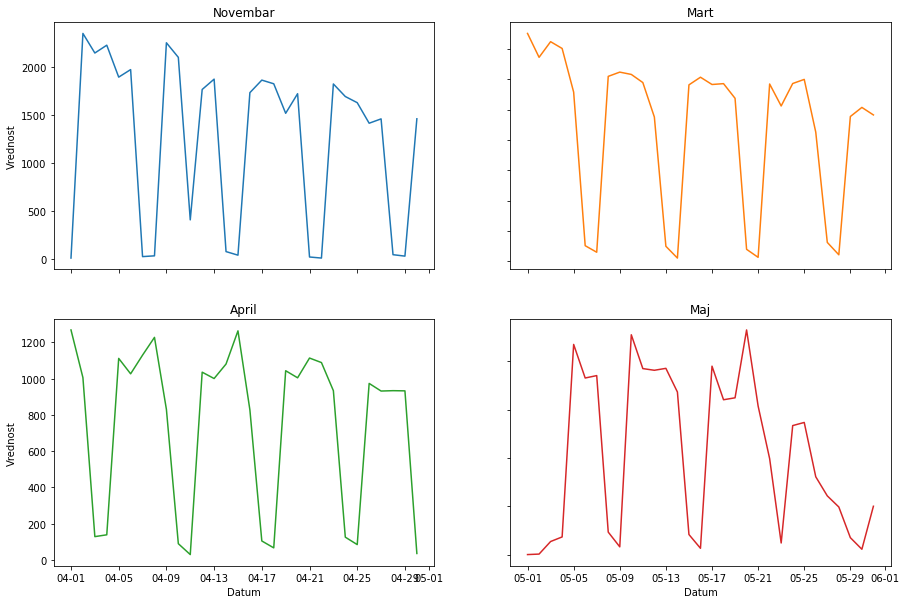

In [57]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))
date_form = DateFormatter("%m-%d")


axs[0, 0].plot(meetings_per_day_november.index, meetings_per_day_november.values)
axs[0, 0].set_title('Novembar')
axs[0, 1].plot(meetings_per_day_march.index, meetings_per_day_march.values, 'tab:orange')
axs[0, 1].set_title('Mart')
axs[1, 0].plot(meetings_per_day_april.index, meetings_per_day_april.values, 'tab:green')
axs[1, 0].set_title('April')
axs[1, 0].xaxis.set_major_formatter(date_form)
axs[1, 1].plot(meetings_per_day_may.index, meetings_per_day_may.values, 'tab:red')
axs[1, 1].set_title('Maj')
axs[1, 1].xaxis.set_major_formatter(date_form)


for ax in axs.flat:
    ax.set(xlabel='Datum', ylabel='Vrednost')

for ax in axs.flat:
    ax.label_outer()

Prosecna duzina trajanja sastanaka svaki dan 

In [59]:
#duration_april = april.groupby(['JOIN_DATE']).DURATION.mean()
#plot_df(duration_april, duration_april.index, duration_april.values, title='trajanje april')

In [243]:
#df['Year'] = april.index.year
#df['Month'] = april.index.month
#df['Weekday Name'] = april.index.day_name()

#april.sample(5, random_state=2)

### Stationarity

Vremenska serija je stacionarna ako:
- ima konstantnu srednju vrednost
- ima konstantnu varijansu
- nema sezonsku komponentu

In [60]:
def check_mean(df, name):
    days = df.shape[0]
    one = days//3
    two = 2*days//3

    print(name + ': ')
    print('Prva trecina: {}'.format(df[:one].mean()))
    print('Druga trecina: {}'.format(df[one:two].mean()))
    print('Treca trecina: {}'.format(df[two:].mean()))
    print('Srednja vrednost na celom skupu: {}\n'.format(df.mean()))

In [61]:
check_mean(meetings_per_day_november, 'NOVEMBAR')
check_mean(meetings_per_day_march, 'MART')
check_mean(meetings_per_day_april, 'APRIL')
check_mean(meetings_per_day_may, 'MAJ')

NOVEMBAR: 
Prva trecina: Meeting_count    1498.3
dtype: float64
Druga trecina: Meeting_count    1280.8
dtype: float64
Treca trecina: Meeting_count    958.2
dtype: float64
Srednja vrednost na celom skupu: Meeting_count    1245.766667
dtype: float64

MART: 
Prva trecina: Meeting_count    1334.2
dtype: float64
Druga trecina: Meeting_count    1014.4
dtype: float64
Treca trecina: Meeting_count    970.545455
dtype: float64
Srednja vrednost na celom skupu: Meeting_count    1102.0
dtype: float64

APRIL: 
Prva trecina: Meeting_count    795.1
dtype: float64
Druga trecina: Meeting_count    745.1
dtype: float64
Treca trecina: Meeting_count    714.7
dtype: float64
Srednja vrednost na celom skupu: Meeting_count    751.633333
dtype: float64

MAJ: 
Prva trecina: Meeting_count    350.6
dtype: float64
Druga trecina: Meeting_count    608.6
dtype: float64
Treca trecina: Meeting_count    290.454545
dtype: float64
Srednja vrednost na celom skupu: Meeting_count    412.483871
dtype: float64



 Srednja vrednost je uglavnom konstantna, ali se iz grafika vidi da postoji sezonska komponenta (ponavlja se neki sablon) -> nije stacionarna

### Spajanje u jednu vremensku seriju 

In [62]:
ts = pd.concat([meetings_per_day_november, meetings_per_day_march, meetings_per_day_april, meetings_per_day_may])

In [66]:
ts.shape

(122, 1)

122 dana 

In [67]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122 entries, 2020-11-01 to 2021-05-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Meeting_count  122 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


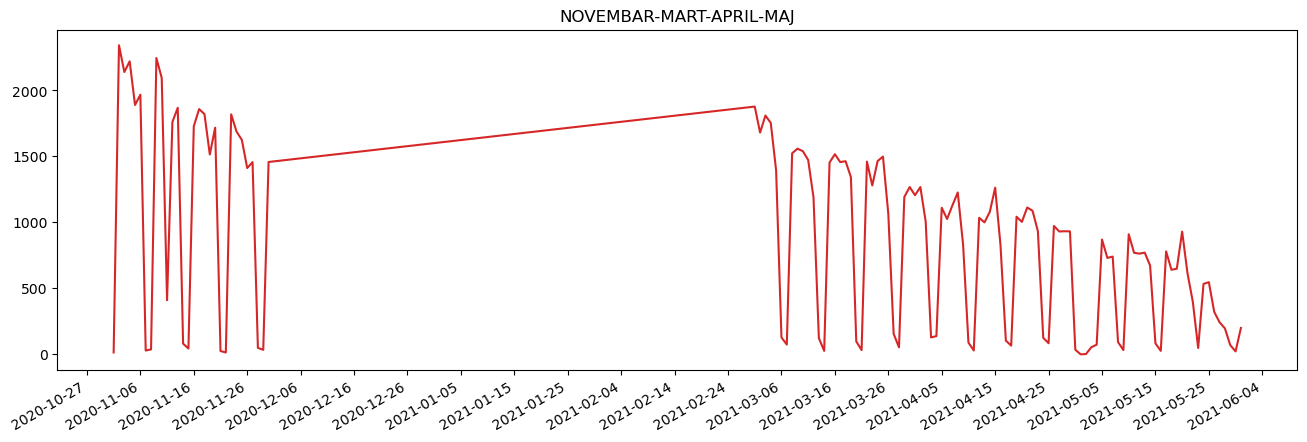

In [68]:
fig = plt.figure(figsize=(16,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(ts.index, ts.values, 'tab:red')
fig.autofmt_xdate()
plt.title('NOVEMBAR-MART-APRIL-MAJ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
plt.show()

Posto fali 3 meseca - vremenski period nije u kontinuitetu, moraju da postoje jednaki vremenski razmaci izmedju svake dve tacke ->  izbacujem novembar:

In [72]:
ts_mam = pd.concat([meetings_per_day_march, meetings_per_day_april, meetings_per_day_may])

ts_mam.describe()

,Meeting_count
count,92.000000
mean,755.413043
std,561.664934
min,0.000000
25%,124.500000
50%,828.500000
75%,1196.250000
max,1878.000000


92 dana

In [81]:
ts_mam.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2021-03-01 to 2021-05-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Meeting_count  92 non-null     int64
dtypes: int64(1)
memory usage: 1.4 KB


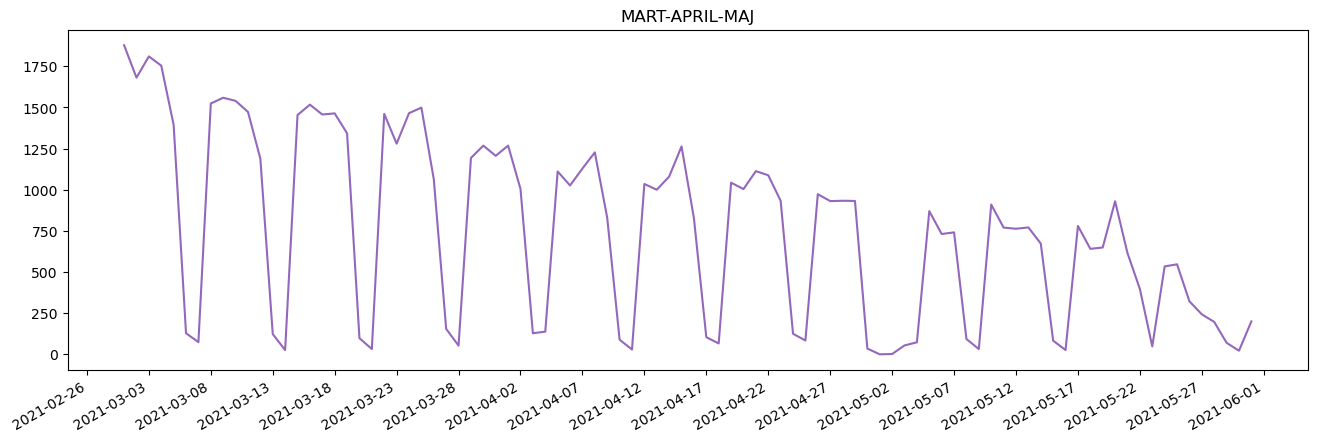

In [83]:
fig = plt.figure(figsize=(16,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(ts_mam.index, ts_mam.values, 'tab:purple')
fig.autofmt_xdate()
plt.title('MART-APRIL-MAJ')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.show()

In [89]:
# ako hocu samo radne dane:
# ts_mam = ts_mam.asfreq('b')

## QQ plot

In [91]:
ts_mam.values

array([[1878],
       [1681],
       [1810],
       [1754],
       [1394],
       [ 128],
       [  74],
       [1524],
       [1559],
       [1540],
       [1473],
       [1189],
       [ 123],
       [  26],
       [1454],
       [1517],
       [1457],
       [1464],
       [1343],
       [  98],
       [  32],
       [1461],
       [1280],
       [1465],
       [1499],
       [1064],
       [ 155],
       [  53],
       [1193],
       [1268],
       [1206],
       [1268],
       [1005],
       [ 128],
       [ 138],
       [1111],
       [1026],
       [1129],
       [1227],
       [ 830],
       [  89],
       [  29],
       [1035],
       [1000],
       [1080],
       [1263],
       [ 827],
       [ 104],
       [  66],
       [1043],
       [1004],
       [1113],
       [1088],
       [ 933],
       [ 125],
       [  84],
       [ 973],
       [ 931],
       [ 933],
       [ 932],
       [  35],
       [   0],
       [   2],
       [  54],
       [  73],
       [ 870],
       [ 7

In [90]:
scipy.stats.probplot(ts_mam, plot=pylab)
pylab.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 92 and the array at index 1 has size 1

- RED LINE = what the data points should follow if they are **normally distributed**

- X-axis = Theoretical quantiles -> How many standard deviations away from the mean these values are

Zakljucak: podaci nemaju normalnu raspodelu

### Stationarity

In [219]:
#check_mean(ts, 'NOVEMBAR-MART-APRIL-MAJ')

Srednja vrednost nije konstantna --> nije stacionarna

In [92]:
check_mean(ts_mam, 'MART-APRIL-MAJ')

MART-APRIL-MAJ: 
Prva trecina: Meeting_count    1098.533333
dtype: float64
Druga trecina: Meeting_count    766.290323
dtype: float64
Treca trecina: Meeting_count    412.483871
dtype: float64
Srednja vrednost na celom skupu: Meeting_count    755.413043
dtype: float64



## Dekompozicija

Simply put, time series decomposition is a process of deconstructing a time series into the following components:

- Trend — general movement over time
- Seasonal — behaviors captured in individual seasonal periods
- Residual — everything not captured by trend and seasonal components

There are two techniques for combining time series components:

- Additive
- Multiplicative

We care about these because time series decomposition requires you to specify a model type for the seasonal component. The default is additive, but you can easily change that.

The term additive means individual components (trend, seasonality, and residual) are added together:
An additive trend indicates a linear trend, and an additive seasonality indicates the same frequency (width) and amplitude (height) of seasonal cycles.
The term multiplicative means individual components (trend, seasonality, and residuals) are multiplied together: A multiplicative trend indicates a non-linear trend (curved trend line), and a multiplicative seasonality indicates increasing/decreasing frequency (width) and/or amplitude (height) of seasonal cycles

In [93]:
def decompose(data):
    res = seasonal_decompose(data, model = "additive",period = 7)
    
    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(10,8))
    res.trend.plot(ax=ax1,ylabel = "trend")
    res.resid.plot(ax=ax2,ylabel = "seasoanlity")
    res.seasonal.plot(ax=ax3,ylabel = "residual")
    print(res.trend)
    plt.tight_layout()
    plt.show()

In [94]:
#decompose(ts)

Date
2021-03-01            NaN
2021-03-02            NaN
2021-03-03            NaN
2021-03-04    1245.571429
2021-03-05    1195.000000
                 ...     
2021-05-27     276.428571
2021-05-28     228.714286
2021-05-29            NaN
2021-05-30            NaN
2021-05-31            NaN
Name: trend, Length: 92, dtype: float64


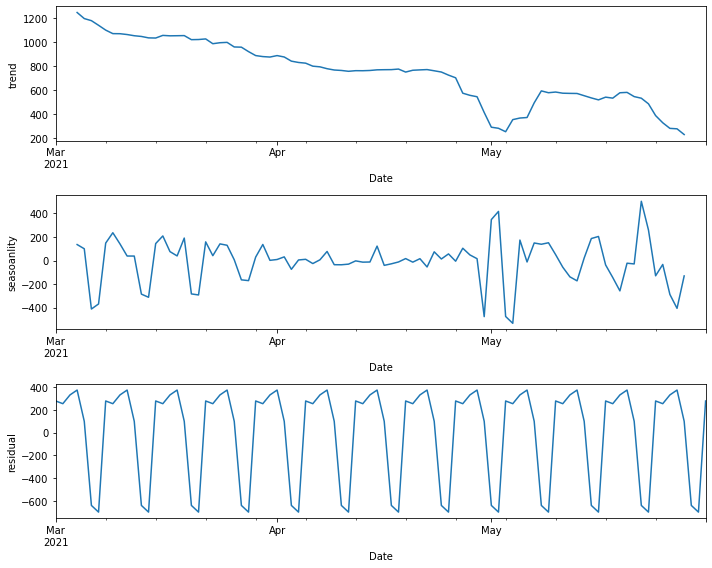

In [95]:
decompose(ts_mam)

## Autokorelacija

So when performing ACF it is advisable to remove any trend present in the data and to make sure the data is stationary.

In [224]:
#acf -> remove trend 
#plt.figure(figsize=(10, 5))
#diff = np.diff(ts.values)
#plt.plot(ts.index[:-1], diff)
#plt.show()

ValueError: x and y must have same first dimension, but have shapes (91,) and (92, 0)

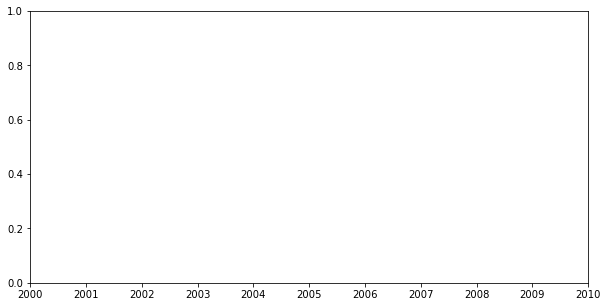

In [97]:
plt.figure(figsize=(10, 5))
diff_mam = np.diff(ts_mam.values)
plt.plot(ts_mam.index[:-1], diff_mam)
plt.title('Uklonjen trend')
plt.show()

In [226]:
#plot_acf(diff)
#plt.show()

We will focus on the points that lie beyond the blue region as they signify strong statistical significance.

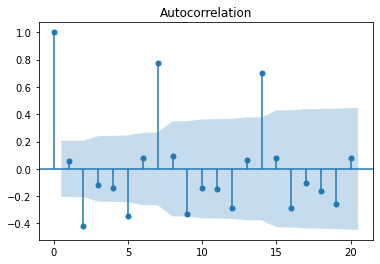

In [253]:
plot_acf(diff_mam)
plt.show()

## Podela na trening i test

Obicno je podela 80% - 20% 

In [98]:
# probacu sa 70-30

size = int(len(ts_mam)*0.7)

In [99]:
df_train = ts_mam.iloc[:size]
df_train.tail()

,Meeting_count
Date,
2021-04-29,932
2021-04-30,35
2021-05-01,0
2021-05-02,2
2021-05-03,54


In [100]:
df_test = ts_mam.iloc[size:]
df_test.head()

,Meeting_count
Date,
2021-05-04,73
2021-05-05,870
2021-05-06,731
2021-05-07,741
2021-05-08,93
